#### Import modules

In [3]:
# !pip install -r requirements_netflix_jung.txt
# !pip install -r requirements_netflix_jung_lite.txt

# !pip list

In [5]:
# import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import string
import os
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D 
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models
from gensim.test.utils import datapath
from gensim.test.utils import common_texts, get_tmpfile

# spacy for lemmatization
import spacy

import os.path
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text
from sklearn.manifold import TSNE
# from transformers import BertTokenizer, TFBertModel
# from bert_embedding import BertEmbedding
# import matplotlib.cm as cm
# import seaborn as sns
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS
# from adjustText import adjust_text
# # import umap
# import umap.umap_ as umap
# # import umap.plot

#### Import the dominant topics based on the chosen model

In [6]:
mallet_lda_df = pd.read_pickle('lda_mallet_model/mallet_lda_df.pkl')
df = pd.read_pickle('raw_data/netflix.pkl')
df = pd.concat([mallet_lda_df.reset_index(drop=True), df.loc[:, ['star_rating', 'helpful_votes', 'total_votes', 'review']].reset_index(drop=True)], axis = 1)

#### Check the topic labels(which are to be the target variables)

In [7]:
topic_dict = {0.: "Platform/Device", 1.: "User Experience", 2.: "Value", 3.: "Service", 4.: "Trouble-shooting", 5.:"Shows"}

In [8]:
representative_topics = df.groupby('Dominant_Topic').max().loc[:, "Perc_Contribution"]
pairs = list(zip(representative_topics.index, representative_topics.values))
representative_topics = df.loc[df.apply(lambda x: (x.Dominant_Topic, x.Perc_Contribution) in pairs, axis = 1),:].sort_values('Dominant_Topic')
representative_topics.loc[:, 'Dominant_Topic'] = ['0. Platform/Device', '1. User', '2. Value', '3. Service', '4. Trouble-shooting', '5. Shows']
representative_topics.loc[:, 'review'] = representative_topics.loc[:, 'review'].map(lambda x: x[:500])

In [9]:
representative_topics.style.set_properties(subset=['review'], **{'width': '400px'})

,Dominant_Topic,Perc_Contribution,Keywords,Text,star_rating,helpful_votes,total_votes,review
3633,0. Platform/Device,0.893600,"time, work, app, fire, love, phone, movie, tablet, download, kindle","['people', 'internet', 'buffer', 'much_movie', 'like_good', 'app', 'movie', 'movie', 'couch', 'bed', 'want_watch', 'watch_movie', 'like_fact', 'sure_get', 'work', 'time', 'long_load', 'time', 'customer_year', 'kindle', 'pod', 'wifi', 'mcdonald']",4,2,3,very good I like this app overall but I don't like that their can only be two people on it at a time. It would be better if you could use it without Internet. Sometimes it takes a long to to load or buffer an it makes you shows blurry. There is not as much movies and shows that some other thing like netflix have. Netflix is very good app for sitting down with you family and watching a movie or being alone and watching a show or movie on the couch or even in your bed. Netflix has a lot of great m
10412,1. User,0.923200,"movie, kid, profile, account, selection, family, child, shows_movie, site, watch","['content', 'availability', 'example', 'child', 'age', 'selection', 'child', 'family', 'content_time', 'kid', 'access', 'horror', 'wish', 'setting', 'viewing', 'genre', 'parent']",4,10,12,"NETFLIX is great! I really enjoy using NETFLIX. It is user-friendly, very convenient and inexpensive.The one thing I would change about NETFLIX is the content availability, for example, my children, ages 7 and 8 love to watch movies on NETFLIX and they do have a great selection of children/family content, but at the same time, my kids have access to R-rated, gay-lesbian, horror, etc. I wish they had a setting which I could prevent them from viewing those genres. For now, I just cl"
6378,2. Value,0.923500,"movie, program, cable, tv, show, selection, love, service, year, choice","['fee', 'considering', 'cost', 'movie_theater', 'ticket', 'bargain', 'amount', 'commercial', 'movie', 'closed_caption', 'home', 'br', 'drive', 'theater', 'long_line', 'could_ask']",4,1,2,"It's worth the monthly fee! Considering the cost of a movie theater ticket, what a bargain! I can enjoy a movie without a considerable amount of commercials, if I am interruped, I can pause the movie and if I am hard of hearing, most movies have closed caption! I caneven make my own popcorn at home! I can also just stop the movie if it think it's something not of my liking, and start another!!I don't have to drive to and from the theater, no long lines, etc. and if you happen to"
6386,3. Service,0.943300,"service, streaming, time, product, year, price, customer, movie, film, option","['app', 'arrogance', 'application', 'team', 'market', 'research', 'etc', 'film', 'matter', 'team', 'people', 'option', 'sheep', 'navigation', 'ring', 'option', 'amazon_prime', 'service', 'end', 'credit', 'oblivion', 'prompt']",1,21,29,"Netflix and the Arrogant App The arrogance of this application is amazing. I am sure some ""team"" thought they new enough, did enough market research, etc. to believe the credits to a film don't matter. The ""team"" also apparently believes giving people fewer options is better because it's all just too advanced for us sheep to understand. I now have to scroll more, hit the back button more, use the navigation ring on Fire TV remote more, and I don't enjoy Netflix as much as I us"
11845,4. Trouble-shooting,0.934800,"app, video, problem, issue, update, time, device, fire, work, fix","['browsing', 'bit', 'browsing', 'bit', 'guess', 'task', 'thread', 'background', 'developer', 'issue', 'priority', 'fix', 'experience', 'browsing', 'available_movie', 'second', 'drag', 'request', 'stuff']",3,0,0,"good, browsing ui can be a bit too sluggish Streaming works fairly well. I've noticed that the browsing UI can be a bit sluggish. My guess is that some tasks are being handled in the UI thread, which should actually be delegated to a background thread (I'm a professional developer). This issue should be a high priority fix -- it really detracts fro

#### Start Modeling BERT
#### Code from [ktrain](https://github.com/amaiya/ktrain/)
Using the topic labels as the target label, use BERT to classify the unseen data, and compare the results with the LDA model's prediction on the unseen data to see which model classified the unseen review better.
<br><br>
[Hugging Face](https://github.com/huggingface/transformers) may be a common package to use.

#### In the training set, exclude examples that have 1/6 chance in the dominant topic. Because that means the dominant topic is just as likely as the other five topics.

In [10]:
mask = df.Perc_Contribution > 0.1667
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df.loc[mask, ['review', 'Dominant_Topic']],
                                                                   text_column = 'review',
                                                                   label_columns = 'Dominant_Topic',
                                                                   maxlen=512,
                                                                   preprocess_mode='bert')

/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')
/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


['Dominant_Topic_0.0', 'Dominant_Topic_1.0', 'Dominant_Topic_2.0', 'Dominant_Topic_3.0', 'Dominant_Topic_4.0', 'Dominant_Topic_5.0']
      Dominant_Topic_0.0  ...  Dominant_Topic_5.0
1493                 0.0  ...                 0.0
2044                 0.0  ...                 0.0
6515                 0.0  ...                 1.0
8346                 0.0  ...                 0.0
2194                 0.0  ...                 0.0

[5 rows x 6 columns]
['Dominant_Topic_0.0', 'Dominant_Topic_1.0', 'Dominant_Topic_2.0', 'Dominant_Topic_3.0', 'Dominant_Topic_4.0', 'Dominant_Topic_5.0']
       Dominant_Topic_0.0  ...  Dominant_Topic_5.0
1635                  0.0  ...                 0.0
11119                 0.0  ...                 0.0
8730                  0.0  ...                 1.0
12274                 0.0  ...                 1.0
10588                 0.0  ...                 0.0

[5 rows x 6 columns]
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [11]:
%%time
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.
CPU times: user 51.4 s, sys: 1.69 s, total: 53.1 s
Wall time: 1min 2s


In [12]:
%%time
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=1)

CPU times: user 379 ms, sys: 479 ms, total: 858 ms
Wall time: 1.29 s


In [13]:
%%time
learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
9149/9149 [==============================] - 4679s 511ms/step - loss: 1.5420 - accuracy: 0.3818 - val_loss: 1.3246 - val_accuracy: 0.4838
CPU times: user 1h 26min 51s, sys: 10min 59s, total: 1h 37min 51s
Wall time: 1h 18min 23s


In [14]:
# %%time
# learner.fit_onecycle(2e-5, 2)

In [15]:
# %%time
# learner.fit_onecycle(2e-5, 1)

In [16]:
%%time
# save model and Preprocessor instance after partially training
# ktrain.get_predictor(model, preproc).save('bert_model')
ktrain.get_predictor(model, preproc).save('bert_model_v0271')

CPU times: user 1.41 s, sys: 2.08 s, total: 3.49 s
Wall time: 5.39 s


In [21]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [25]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  
  file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
      }
  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                media_body=media,
                                fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


In [26]:
save_file_to_drive('/', '/content/bert_model_v0271/tf_model.h5')

File ID: 1sN4Fzy49nFbxrO4ivF9Y-b0fSbN_23Cd


{'id': '1sN4Fzy49nFbxrO4ivF9Y-b0fSbN_23Cd'}

In [ ]:
# %%time
# learner.fit_onecycle(2e-5, 2)

In [ ]:
# %%time
# learner.fit_onecycle(2e-5, 1)

In [27]:
%%time
# # reload Predictor and extract model
model = ktrain.load_predictor('bert_model_v0271').model

# # re-instantiate Learner and continue training
# learner = ktrain.get_learner(model=model,
#                              train_data=(x_train, y_train),
#                              val_data=(x_test, y_test),
#                              batch_size=1)
# learner.fit_onecycle(2e-5, 1)

CPU times: user 7.95 s, sys: 1.13 s, total: 9.08 s
Wall time: 8.7 s


In [ ]:
%%time
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('bert_model_v0271_part2')

### Predicting Topic with unseen text(validation set)

In [29]:
BERT_preds, BERT_proba = pd.read_pickle('prediction/BERT_preds.pkl'), pd.read_pickle('prediction/BERT_proba.pkl')
LDA_preds, LDA_proba = pd.read_pickle('prediction/LDA_preds.pkl'), pd.read_pickle('prediction/LDA_proba.pkl')

In [ ]:
# BERT_preds
# BERT_proba
# LDA_preds
# LDA_proba

In [ ]:
# Import hold_out validation dataset
df = pd.read_pickle('raw_data/netflix_val.pkl')
reviews = df.review.values.tolist()

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

%time predicted_topics = predictor.predict(reviews)
BERT_preds = [float(topic) for topic in predicted_topics]

%time BERT_proba = predictor.predict_proba(reviews)

In [ ]:
# pd.to_pickle(BERT_preds, 'prediction/BERT_preds.pkl')
# pd.to_pickle(BERT_proba, 'prediction/BERT_proba.pkl')

#### Compare with LDA model

Only 43% of the predicted labels are the same..

In [36]:
mask = LDA_preds == np.array(BERT_preds)
sum(mask) / len(BERT_preds)

0.4322775744071303

### Predicting Topic with ad-hoc text

In [37]:
new_text = "I think I really like the app. Thanks for making this useful app."

In [39]:
model = ktrain.load_predictor('bert_model').model
preproc = ktrain.load_predictor('bert_model').preproc
predictor = ktrain.get_predictor(model, preproc)

In [40]:
predictor.predict(new_text, return_proba=True)

array([0.20511928, 0.13379347, 0.19580276, 0.16515256, 0.07823511,
       0.2218969 ], dtype=float32)

In [41]:
percentages = predictor.predict(new_text, return_proba=True)
topics = ["Platform/Device", "User Experience", "Value", "Service", "Trouble-shooting", "Shows"]
indices = np.argsort(percentages)[::-1]
[topics[index] for index in indices]

['Shows',
 'Platform/Device',
 'Value',
 'Service',
 'User Experience',
 'Trouble-shooting']

In [42]:
[100*np.round(percentages[index], 3) for index in indices]

[22.200000286102295,
 20.499999821186066,
 19.599999487400055,
 16.500000655651093,
 13.40000033378601,
 7.800000160932541]

### Plotting the word embeddings

There's 9149 documents with 512 dimensions for embedding in training set and 6283 documents with 512 dimensions for embedding in validation set.

### TSNE
According to the [source code](https://github.com/amaiya/ktrain/blob/master/ktrain/text/preprocessor.py), BERTPreprocessor's preprocess function returns (preprocessed x, preprocessed y)

In [ ]:
preproc_val = preproc.preprocess(reviews)
preprocessed_X = preproc_val[0]
tsne = TSNE(n_components=3, random_state = 0)

In [ ]:
%time tsne_3d_coordinates = tsne.fit_transform(preprocessed_X)

CPU times: user 9min 17s, sys: 15.8 s, total: 9min 32s
Wall time: 1min 36s


#### Representative embeddings with 99.5% probability

In [ ]:
print(BERT_proba.argmax(axis=0))
print(BERT_proba.max(axis=0).round(5))
# Platform/Device, User, Value, Service, Trouble-shooting, Shows

[4297 1571  452 3311 2763    7]
[0.99865 0.99931 0.99965 0.99992 0.99975 1.     ]


In [ ]:
df_reset_index = df.reset_index(drop=True)
representative_reviews = df_reset_index.iloc[BERT_proba.argmax(axis=0), :]['review'].values

### BERT visualization

In [ ]:
total_indices = np.array(range(len(BERT_proba)))
major_docs = total_indices[BERT_proba.max(axis=1) >= 0.99]
x_coords, y_coords, z_coords = tsne_3d_coordinates[major_docs,0], tsne_3d_coordinates[major_docs,1], tsne_3d_coordinates[major_docs, 2]
len(major_docs)

1176

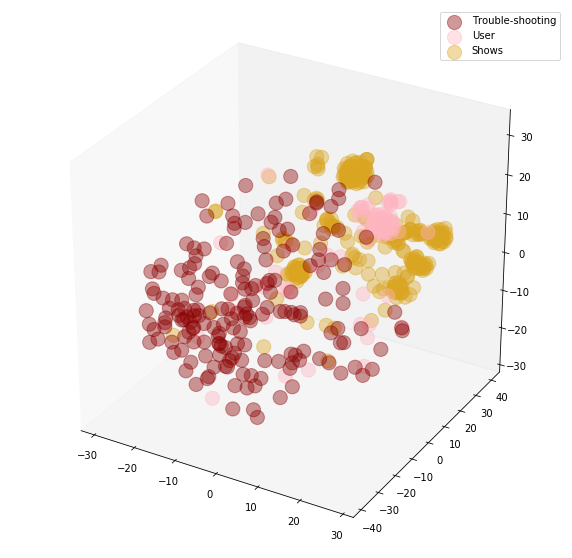

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
colors = ['green', 'lightpink', 'gray', 'dodgerblue', 'darkred', 'goldenrod']
for label in [4, 1, 5]:
    mask = np.array(BERT_preds)[major_docs] == label
    ax.scatter3D(x_coords[mask], y_coords[mask], z_coords[mask], c=colors[label], label=topic_dict[label], alpha=.4, marker = 'o', s=200)

# for label in [0, 2, 3]:
#     mask = np.array(BERT_preds)[major_docs] == label
#     ax.scatter3D(x_coords[mask], y_coords[mask], z_coords[mask], facecolor=(1,1,1,0), edgecolor=colors[label],alpha=1, label=topic_dict[label], marker = '^', s=10)

ax.grid(False)
ax.legend();
# plt.savefig('images/{}'.format("bert_tsne"), dpi=200, transparent=True, bbox_inches = "tight");

In [ ]:
print(matplotlib.colors.to_rgba("green"), matplotlib.colors.cnames["lightpink"], matplotlib.colors.cnames["gray"],
      matplotlib.colors.cnames["dodgerblue"], matplotlib.colors.cnames["darkred"], matplotlib.colors.cnames["goldenrod"])

(0.0, 0.5019607843137255, 0.0, 1.0) #FFB6C1 #808080 #1E90FF #8B0000 #DAA520


### Wordcloud

In [ ]:
reviews_df = pd.concat([pd.Series(reviews), pd.Series(BERT_preds)], axis = 1)
reviews_df.columns = ['review', 'pred']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

tokenized_text = []
for review in reviews_df.loc[:,'review']:
    tokenized_text.append(tokenizer.tokenize(review))

In [ ]:
def one_string(texts, boolean_mask):
    thing = ' '.join([' '.join(item) for item in [row for row, boolean in zip(texts, boolean_mask) if boolean]])
    thing = re.sub(r'[ ]{2,}', ' ', thing)
    return re.sub(r'#', '', thing)

def create_wordcloud(img_directory, id, contour_width=3, contour_color='green', background_color="white"):
    topic_ids = np.array(reviews_df.pred)
    mask = np.array(Image.open(img_directory))
    stop_words = set(stopwords.words('english')) | {'<','>',"'",'-','/',',','!','.','br','&',';','?',')','#','##s','##ing','le','ha','wa',
                                                'would','great','watch','stars','netflix','app','like','tv','five','good','love','one','show','star', 'stars'
                                                'shows','time','kind','movie','movies','##le','watching','want','get','really','could','four', 'also', 'to', 'it', 'even'}
    # Removed words that appeared in all or most topics
    wc = WordCloud(background_color=background_color, max_words=15, mask=mask, stopwords=stop_words,
                   max_font_size=100, random_state=40, contour_width=contour_width, contour_color=contour_color)
    wc.generate(one_string(tokenized_text, topic_ids == id))
    return wc

In [ ]:
# plt.figure(figsize=(10,6))
# plt.title('Trouble-shooting(Video-related)', fontsize=20); plt.imshow(create_wordcloud('images/problem.png', 4,contour_color='darkred'), interpolation='spline36'); plt.axis("off");
# plt.savefig('images/{}'.format("bert_trouble"), dpi=200, transparent=True, bbox_inches = "tight")
# plt.figure(figsize=(10,6))
# plt.title('User Experience', fontsize=20); plt.imshow(create_wordcloud('images/family.png', 1,contour_color='lightpink'), interpolation='spline36'); plt.axis("off");
# plt.savefig('images/{}'.format("bert_user"), dpi=200, transparent=True, bbox_inches = "tight")
# plt.figure(figsize=(10,6))
# plt.title('Shows', fontsize=20); plt.imshow(create_wordcloud('images/show.png', 5,contour_color='goldenrod'), interpolation='spline36'); plt.axis("off");
# plt.savefig('images/{}'.format("bert_shows"), dpi=200, transparent=True, bbox_inches = "tight")

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
ax[0,0].set_title('Platform/Device', fontsize=20); ax[0,0].imshow(create_wordcloud('images/android.png', 0), interpolation='spline36'); ax[0,0].axis("off")
ax[0,1].set_title('User Experience', fontsize=20); ax[0,1].imshow(create_wordcloud('images/family.png', 1,contour_color='lightpink'), interpolation='spline36'); ax[0,1].axis("off")
ax[0,2].set_title('Value', fontsize=20); ax[0,2].imshow(create_wordcloud('images/think.png', 2,contour_color='gray'), interpolation='spline36'); ax[0,2].axis("off")
ax[1,0].set_title('Service', fontsize=20); ax[1,0].imshow(create_wordcloud('images/service.png', 3,contour_color='dodgerblue'), interpolation='spline36'); ax[1,0].axis("off")
ax[1,1].set_title('Trouble-shooting(Video-related)', fontsize=20); ax[1,1].imshow(create_wordcloud('images/problem.png', 4,contour_color='darkred'), interpolation='spline36'); ax[1,1].axis("off")
ax[1,2].set_title('Shows', fontsize=20); ax[1,2].imshow(create_wordcloud('images/show.png', 5,contour_color='goldenrod'), interpolation='spline36'); ax[1,2].axis("off");

plt.savefig('images/{}'.format("bert_wordcloud"), dpi=200, transparent=True, bbox_inches = "tight")

#### Keywords and frequencies stored in a list of dictionaries "frequencies_topics"

In [ ]:
UPPER = 10
stop_words = set(stopwords.words('english')) | {'<','>',"'",'-','/',',','!','.','br','&',';','?',')','#','##s','##ing','le','ha','wa',
                                            'would','great','watch','stars','netflix','app','like','tv','five','good','love','one',
                                            'shows','time','kind','movie','movies','##le','watching','want','get','really','could','four', 'also', 'to', 'it', 'even'}
# Removed words that appeared in all or most topics

frequencies_topics = [0]*6
for topic_id in range(6):
    frequencies = defaultdict(int)
    for review in reviews_df.loc[reviews_df.pred == topic_id, 'review']:
        for word in tokenizer.tokenize(review):
            if word not in stop_words:
                frequencies[word] += 1
    keys = list(frequencies.keys())
    frequent_indices = np.argsort(list(frequencies.values()))[::-1][:UPPER]
    frequent_words = set(np.array(keys)[frequent_indices])
    frequencies_topics[topic_id] = frequent_words
    
    print(f"Topic: {topic_dict[topic_id]}")
    print(frequent_words,'\n')

### TSNE 3d plot

In [ ]:
# # !pip uninstall umap
# !pip uninstall umap-learn
# !pip install umap-learn

In [ ]:
import umap

In [ ]:
%time mapper3d = umap.UMAP(n_components=3, n_neighbors=7, random_state=0).fit(preprocessed_X)

NameError: name 'mapper3d' is not defined

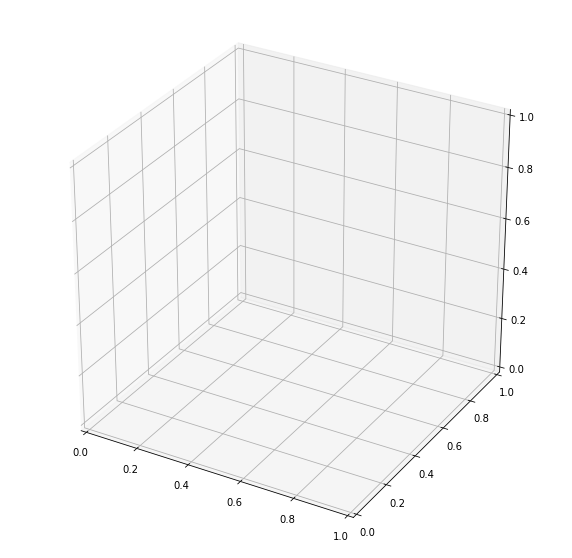

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
coords = mapper3d.embedding_
x,y,z = coords[major_docs,0], coords[major_docs,1], coords[major_docs,2]
colors = ['green', 'lightpink', 'gray', 'dodgerblue', 'darkred', 'goldenrod']
for label in [4, 1, 5]:
    mask = np.array(BERT_preds)[major_docs] == label
    ax.scatter3D(x[mask],y[mask],z[mask], c=colors[label], label=topic_dict[label], alpha=.3, marker = 'o', s=100)

# for label in [0, 2, 3]:
#     mask = np.array(BERT_preds)[major_docs] == label
#     ax.scatter3D(x[mask], y[mask], z[mask], facecolor=(1,1,1,0), edgecolor=colors[label],alpha=.5, label=topic_dict[label], marker = '.', s=100)
ax.grid(False)
ax.legend();

### TSNE 2d plot

In [ ]:
%time mapper2d = umap.UMAP(n_components=2, n_neighbors=9, random_state=0).fit(preprocessed_X)

AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
coords = mapper2d.embedding_
x,y = coords[major_docs,0], coords[major_docs,1]

In [ ]:
topics_to_plot = [1,4,5]
indices = np.arange(len(preprocessed_X))[np.array([True if label in topics_to_plot else False for label in BERT_preds])]
major_docs_indices = list(set(major_docs).intersection(set(indices)))

In [ ]:
coords = mapper2d.embedding_
# indices = predicted_proba.argmax(axis=0)
x_coords, y_coords = coords[major_docs_indices,0], coords[major_docs_indices,1]
plt.figure(figsize=(12, 6))
# plt.scatter(x_coords, y_coords, marker='.', alpha=0.8, c=np.array(predicted_topics)[major_docs], cmap='viridis', hue = )
# plt.legend();
sns.scatterplot(x=x_coords, y=y_coords, hue=[topic_dict[topic_id] for topic_id in np.array(BERT_preds)[major_docs_indices]], alpha=0.6, s=100, marker='o')
plt.show()
# for label, x, y in zip(['Platform/Device', 'User', 'Value', 'Service', 'Trouble-shooting', 'Shows'], x_coords, y_coords):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points');

### BERT word embeddings 2d visualization with UMAP

In [ ]:
embeddings = pd.read_pickle('bert_model/embeddings.pkl')
# bert_embedding = BertEmbedding()
# %time embeddings = bert_embedding(reviews)

In [ ]:
BERT = pd.concat([pd.Series(BERT_preds), pd.Series(BERT_proba.max(axis=1))],axis=1)
BERT.columns = ['label', 'proba']

representative_docs, representative_docs_umap, tokens_per_doc = [], [], []

token_stopwords = set(stopwords.words('english')) | {"'",'.', ",", "would", "goes", "2", '-', 'five', 'stars'}
tsne = TSNE(n_components=2, random_state = 0)

for i in range(6):
    BERT_ = BERT.loc[BERT.label==i,:]
    representative_docs.append(BERT_.index[np.argmax(BERT_.proba)])# Most representative documents per topic
    tokens, embeds = embeddings[representative_docs[i]][0], embeddings[representative_docs[i]][1]
    indices = [i for (i, token) in enumerate(np.array(tokens)) if token not in token_stopwords]# Remove the stopwords from each topic
    clean_tokens = [tokens[i] for i in indices]
    
    tokens_per_doc.append(clean_tokens)    
    try:# Try UMAP first, and if it throws an error, try TSNE
        mapper2d = umap.UMAP(n_components=2, n_neighbors=2, random_state=1).fit(np.array([embeds[i] for i in indices]))
        representative_docs_umap.append(mapper2d.embedding_)
    except:
        representative_docs_umap.append(tsne.fit_transform(np.array([embeds[i] for i in indices])))

In [ ]:
ax = plt.figure(figsize=(10,10))
colors = ['green', 'lightpink', 'gray', 'dodgerblue', 'darkred', 'goldenrod']
for label in range(6):
    word_embeddings = representative_docs_umap[label]
    tokens = tokens_per_doc[label]
    x, y = word_embeddings[:, 0], word_embeddings[:, 1]
    plt.scatter(x, y, c=colors[label], label=topic_dict[label], alpha=0.6, marker = 'o', s=200);
    texts = [plt.text(x[i], y[i], tokens[i], ha='center', va='center') for i in range(len(x))]
    adjust_text(texts, avoid_points = False, expand_text = (1.05, 4.5))
ax.legend(loc=6)
ax.savefig('images/{}'.format("bert_cluster"), dpi=200, transparent=True, bbox_inches = "tight");

In [43]:
!pip list

Package                          Version
-------------------------------- -------------------
absl-py                          0.12.0
adjustText                       0.7.3
alabaster                        0.7.12
albumentations                   0.1.12
altair                           4.1.0
appdirs                          1.4.4
argon2-cffi                      20.1.0
arviz                            0.11.2
astor                            0.8.1
astropy                          4.2.1
astunparse                       1.6.3
async-generator                  1.10
atari-py                         0.2.9
atomicwrites                     1.4.0
attrs                            21.2.0
audioread                        2.1.9
autograd                         1.3
Babel                            2.9.1
backcall                         0.2.0
beautifulsoup4                   4.6.3
bleach                           3.3.0
blis                             0.4.1
bokeh                            2.3.3
Bottle